In [1]:
import bayesopt
import matplotlib.pyplot as plt
import seaborn as sns

from jax.config import config; config.update("jax_enable_x64", True)
from functools import partial
import jax.numpy as np

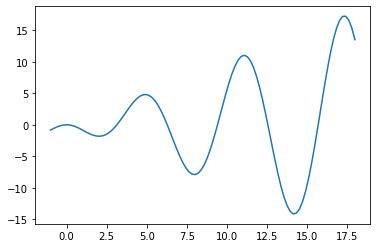

In [4]:
def f(x):
    return -x*np.sin(x)

plt.plot(np.linspace(-1,18,100),f(np.linspace(-1,18,100)))

# BO

In [19]:
# %%timeit
BO = bayesopt.BayesOpt(f=f,
                       initial_input=np.array([0.]),
                       acq=bayesopt.acquisition.LCB,
                       acq_optim=partial(bayesopt.acquisition_optimizer.AcquisitionSLSQPOptimizer,bounds=[0,18]))
              #partial(AcquisitionLBFGSBOptimizer,Xmin=0,Xmax=18))
              #acq_optim=partial(AcquisitionGridOptimizer,bounds=[[0,18]],step=0.01))
              #partial(AcquisitionLBFGSBOptimizer,Xmin=0,Xmax=18))
              #partial(AcquisitionSLSQPOptimizer,Xmin=0,Xmax=10))
              #partial(AcquisitionGridOptimizer,Xmin=0,Xmax=10,step=0.01))
              #partial(AcquisitionLBFGSBOptimizer,Xmin=0,Xmax=10))
             #(self, f, initial_X, acq, acq_optim,*args, **kwargs):
BO.run_optim(20)

BayesOpt: 100%|██████████| 20/20 [00:01<00:00, 12.07it/s, param:[14.19438113], value:-14.171155073874067, current best param:[14.19438113], current best_value:-14.171155073874067]


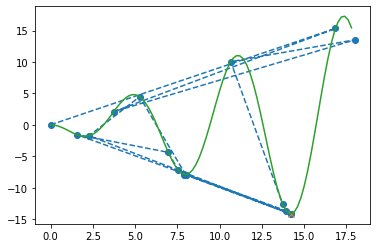

In [20]:
X = np.arange(0,18,0.2)
plt.plot(BO.param_history,BO.value_history,'o--')
plt.plot(BO.best_params,BO.best_value,'x')
plt.plot(X,f(X))

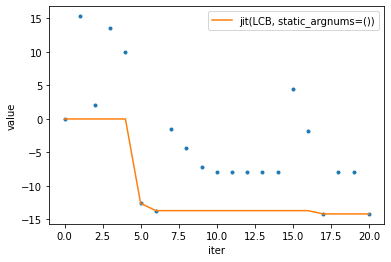

In [21]:
bayesopt.plot_history(BO)

# use original kernel and acq function

In [14]:
dists = bayesopt.utils.pairwise(bayesopt.metric.euclid_distance,square=True)
def kernel(x,y):
    return np.exp(-dists(x,y))
print(kernel(np.array([[2,3],[1,2]]),np.array([[2,3],[1,2],[1,1]])))

[[1.         0.13533528 0.00673795]
 [0.13533528 1.         0.36787944]]


In [25]:
def acq(mu,sigma,*args,**kwargs):
    '''
    mu, sigma, it=it, vmax=vmax, vmin=vminが入力されるようacq optimで決めている.
    '''
    it = kwargs.get('it',5.)
    return -mu+sigma*np.sqrt(np.log(it+1)/(it+1))

In [26]:
BO = bayesopt.BayesOpt(f=f,
                       initial_input=np.array([0.]),
                       kernel=kernel,
                       acq=acq,
                       acq_optim=partial(bayesopt.acquisition_optimizer.AcquisitionSLSQPOptimizer,bounds=[0,18]))
BO.run_optim(20)

BayesOpt: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, param:[2.02142701], value:-1.8196332029078113, current best param:[14.21658622], current best_value:-14.17177477834254]  


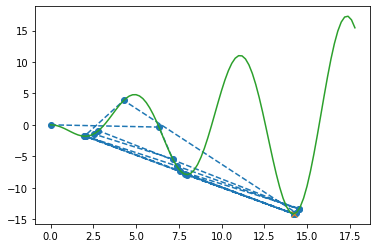

In [27]:
X = np.arange(0,18,0.2)
plt.plot(BO.param_history,BO.value_history,'o--')
plt.plot(BO.best_params,BO.best_value,'x')
plt.plot(X,f(X))

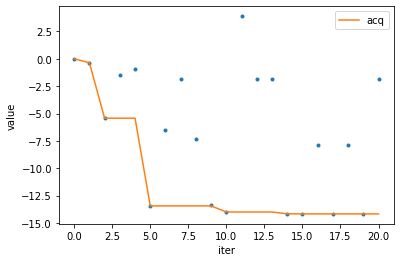

In [28]:
bayesopt.plot_history(BO)

# memo acuisition optimizer

In [29]:
def AcquisitionSLSQPOptimizer(gpr, acq, it, bounds): 
    ## gprとacqとitは受け取れるようにしないといけない. 
    ##boundsはfunctoolのpartialで指定するか、内部変数に持たせるか
    bounds = np.atleast_2d(bounds)
    vmax = np.max(gpr.Y_train)
    vmin = np.min(gpr.Y_train)

    import scipy.optimize  
    def Obj(x):
        mu,sigma = gpr.posterior_predictive(np.atleast_2d(x),return_std=True)
        return -1.*acq(mu,sigma, it=it, vmax=vmax, vmin=vmin).ravel()
    res = scipy.optimize.fmin_slsqp(Obj, 
                                    x0=onp.random.uniform(bounds[:,0],bounds[:,1]), 
                                    bounds=bounds, 
                                    iprint=0, 
                                    full_output=True, 
                                    iter=100)

    return res[0],res[1]

memo terminate functionを設定できるようにした   
入力はit,param_history,value_historyの順番で入る

In [ ]:
def terminate_function(it, param_history, value_history):
    if value_history.min()<1e-1:
        return True
    else:
        return False